Example code to reproduce some plots of figure 2 main paper

#### Import and load

In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from matplotlib import rcParams
import h5py
import hashlib
import time
from typing import List
import sys
import aux_analysis as aux
import spikeye.visualize as v
from sklearn import manifold
from sklearn import decomposition
from synapsbi.utils import apply_n_conditions, load_and_merge

color_input="#36454F"
color_ee = "#A52A2A"
color_ei = (242/256, 140/256, 40/256)
color_ie = (8/256, 143/256, 143/256)
color_ii = (47/256, 85/256, 151/256)

color_pi0 = (127/255, 127/255, 127/255)
color_pi1 = (27/255, 158/256, 119/255)
color_pi2 = (217/255, 95/256, 2/255)
color_pi3 = (117/256, 112/256, 179/256)

In [4]:
save_dir = "../data_synapsesbi/bg_IF_EEEIIEII_6pPol/"

dataset_list = []
dataset_list.append(load_and_merge(save_dir, ("box_prior_metrics.npy",)))
dataset_list.append(load_and_merge(save_dir, ("0rate_filter2_metrics.npy",)))
dataset_list.append(load_and_merge(save_dir, ("0rate_filter2_1wblowwcreep_filter4_metrics.npy",)))
dataset_list.append(load_and_merge(save_dir, ("0r_f2_1wc_f2_metrics.npy",)))

n_datasets = len(dataset_list)
n_thetas = len(dataset_list[0]['theta'][0]) - 1

cond_no_nan = ("rate", 0, 1000)
cond_r = ("rate", 1, 50)
cond_cv = ("cv_isi", 0.7, 1000)
cond_sf = ("spatial_Fano", 0.5, 2.5)
cond_tf = ("temporal_Fano", 0.5, 2.5)
cond_ac = ("auto_cov", 0, 0.1)
cond_fft = ("fft", 0, 1)
cond_wb = ("w_blow", 0, 0.1)
cond_srt = ("std_rate_temporal", 0, 0.5)
cond_srs = ("std_rate_spatial", 0, 5)
cond_scv = ("std_cv", 0, 0.2)
cond_wc = ("w_creep", 0, 0.05)
cond_ri = ("rate_i", 1, 50)
cond_weef =("weef", 0 , 0.5)
cond_weif =("weif", 0 , 0.5)
cond_wief =("wief", 0 , 5)
cond_wiif =("wiif", 0 , 5)

cond_chosen_list = [(cond_r,cond_ri),
                    (cond_wb,cond_wc,cond_weef,cond_weif,cond_wief,cond_wiif),
                    (cond_cv,cond_sf,cond_tf,cond_ac,cond_fft,cond_srt,cond_srs,cond_scv),
                    (cond_r,cond_cv,cond_sf,cond_tf,cond_ac,cond_fft,cond_wb,cond_srt,cond_srs,cond_scv,cond_wc,cond_ri,cond_weef,cond_weif,cond_wief,cond_wiif)]
n_conditions_chosen = len(cond_chosen_list)

fracs_list = np.zeros((n_conditions_chosen, n_datasets))
for i, cond in enumerate(cond_chosen_list):
    for d in range(n_datasets):
        fracs_list[i,d] = np.sum(apply_n_conditions(dataset_list[d], cond))/len(dataset_list[d])

retrieved 10000/10000 simulations
retrieved 5000/5000 simulations
retrieved 10000/10000 simulations
retrieved 50200/50200 simulations


#### Accumulation plot

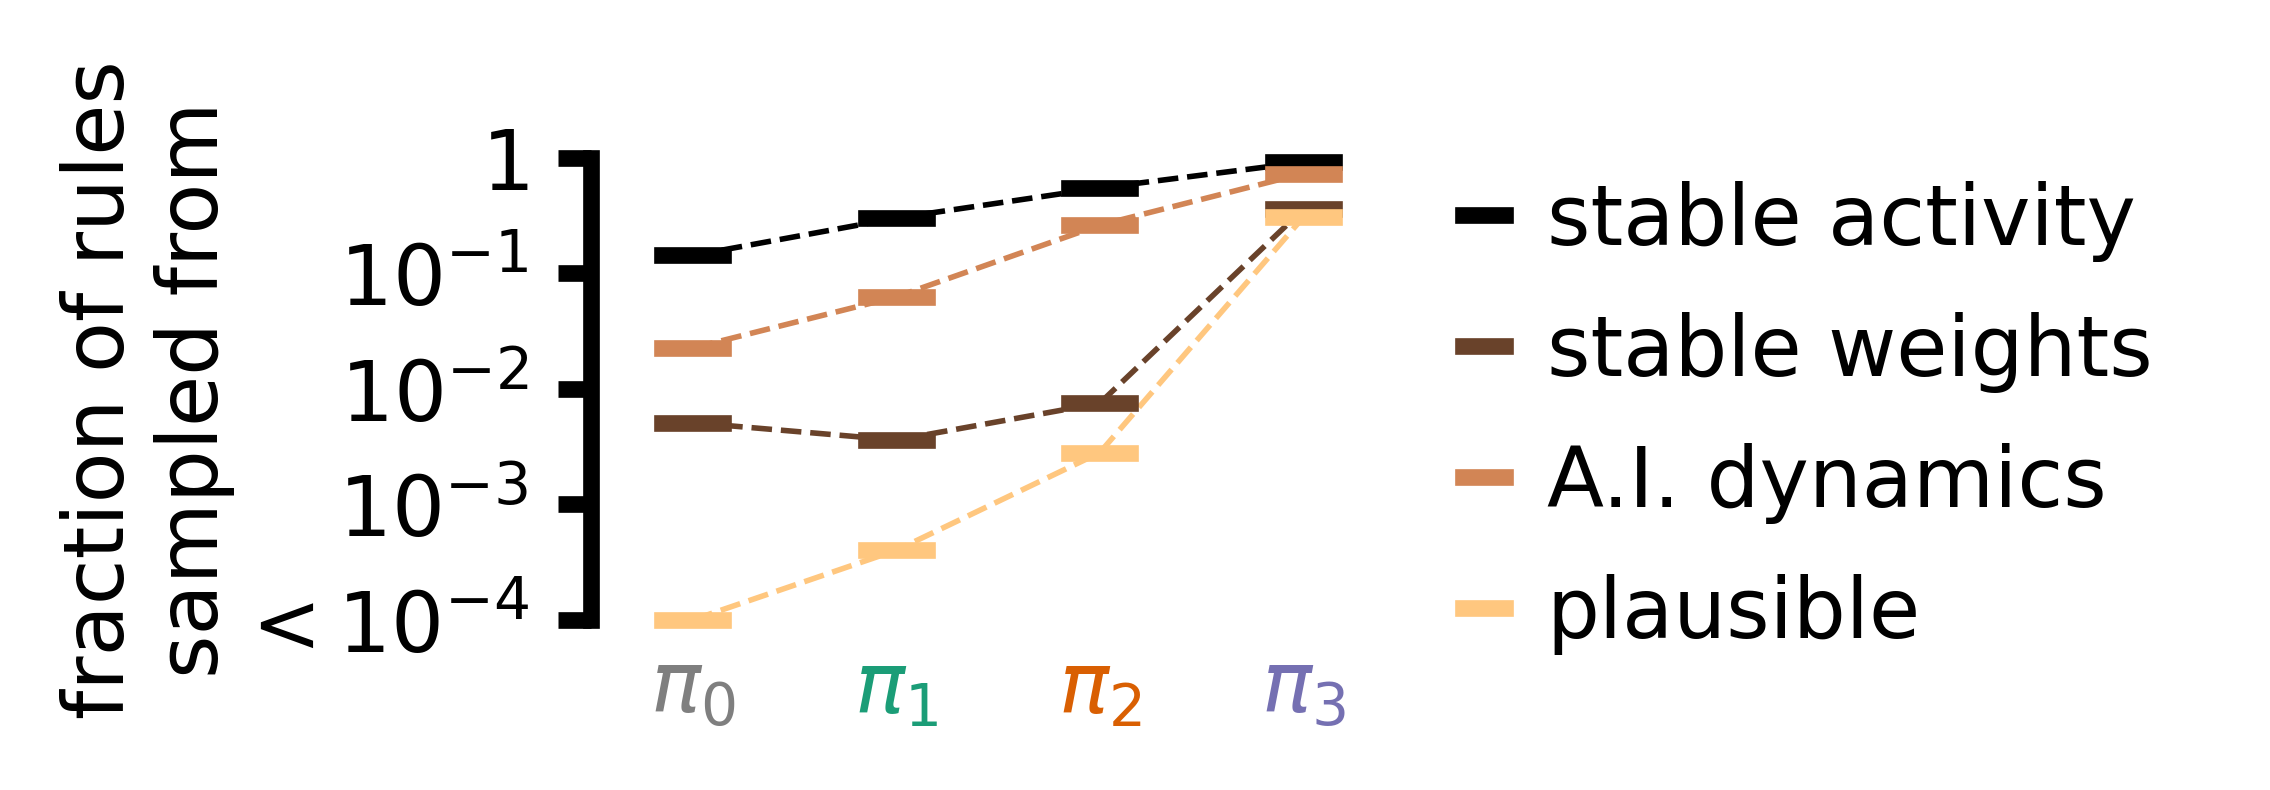

In [6]:
aux.accumulation_plot(fracs_list=fracs_list,
                      colormap=plt.cm.copper,
                      figsize=(1.75, 1),
                      clip_frac_low=1e-4,
                      condition_labels=["stable activity", "stable weights", "A.I. dynamics", "plausible"],
                      ylim=[1e-4,1],
                      yticks=[1e-4,1e-3,1e-2,0.1,1],
                      yticklabels=[r'$<10^{-4}$',r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'$1$'],
                      xlabel=None,
                      xticklabels=[r'$\pi_0$', r'$\pi_1$', r'$\pi_2$', r'$\pi_3$'],
                      ylabel="fraction of rules\nsampled from",
                      y_loc_leg=-0.2,
                      linewidth=2,
                      axwidth=2,
                      font="Arial",
                      fontsize=10,
                      xlim=[-0.5,3.5],
                      ms=0,
                      marker="o",
                      labelspacing=0.6,
                      xlabel_colors = [color_pi0, color_pi1, color_pi2, color_pi3],
                      l=0.15)

#### PCA evolution of dimensionality of posteriors

In [7]:
#we need to rescale the thetas so that for prior they all have mean 0 and variance 1:
dataset_list_whitened = []
for d in range(n_datasets):
    dataset_list_whitened.append(np.copy(dataset_list[d]))
    for theta_num in range(n_thetas):
        if theta_num in [0,1,6,7,12,13,18,19]:
            dataset_list_whitened[d]['theta'][:,theta_num] = (dataset_list_whitened[d]['theta'][:,theta_num] - 0.055)/np.sqrt((0.09**2)/12)
        else:
            dataset_list_whitened[d]['theta'][:,theta_num] = (dataset_list_whitened[d]['theta'][:,theta_num])/np.sqrt((4**2)/12)
            

pca_list = [decomposition.PCA(whiten=True) for i in range(n_datasets)]
explained_variance_ratios = []
for d in range(n_datasets):
    pca_list[d].fit(dataset_list_whitened[d]['theta'][:,:-1])
    explained_variance_ratios.append(pca_list[d].explained_variance_ratio_)
    
explained_variance_ratios = np.array(explained_variance_ratios)
print(explained_variance_ratios.shape)

(4, 24)


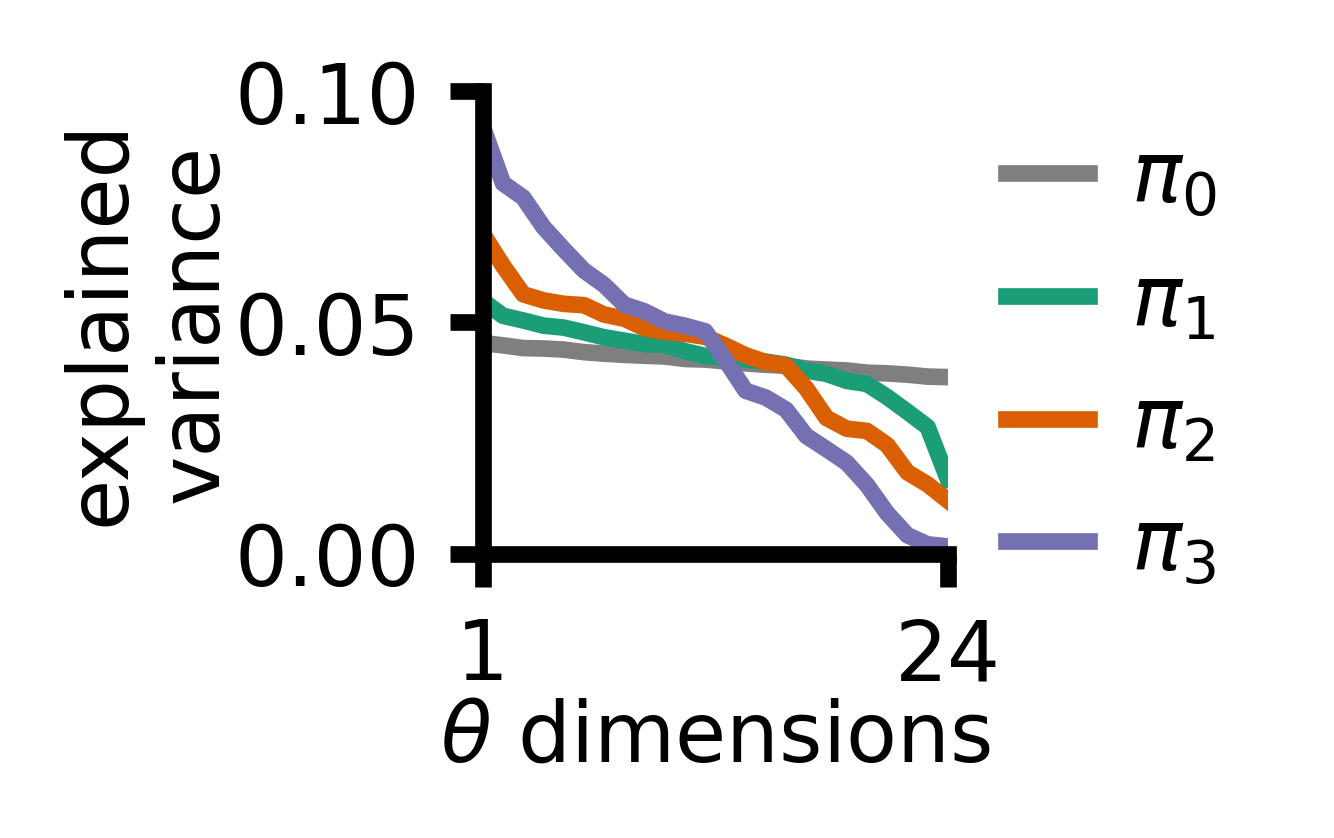

In [8]:
label_plots = ["prior"]
for i in range(n_datasets-1):
    label_plots.append("round " + str(i+1))

aux.plot_evol_dim_post(exp_var_ratios=explained_variance_ratios,
                   font = "Arial",
                   fontsize=10,
                   linewidth=2,
                   axwidth=2,
                   dpi=600,
                   labels=[r'$\pi_0$', r'$\pi_1$', r'$\pi_2$', r'$\pi_3$'],
                   figsize=(1, 1),
                   xticks=[1,24],
                   xlim=[1,24],
                   xlabel=r'$\theta$' + " dimensions",
                   ylim=[0,0.1],
                   ylabel="explained\nvariance",
                   y_loc_leg=-0.2,
                   labelspacing=0.5,
                   colors = [color_pi0, color_pi1, color_pi2, color_pi3])

#### Plot rule under pre-post protocol

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


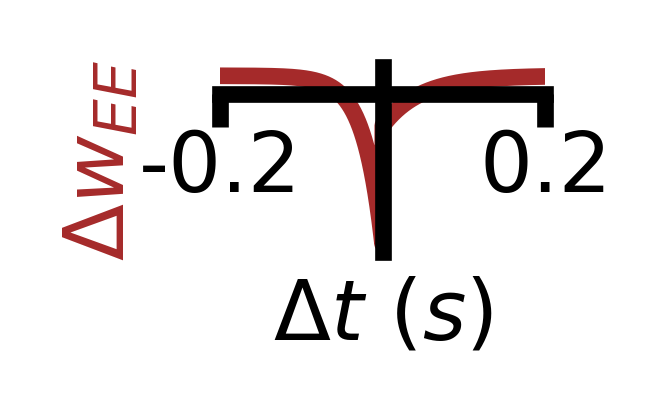

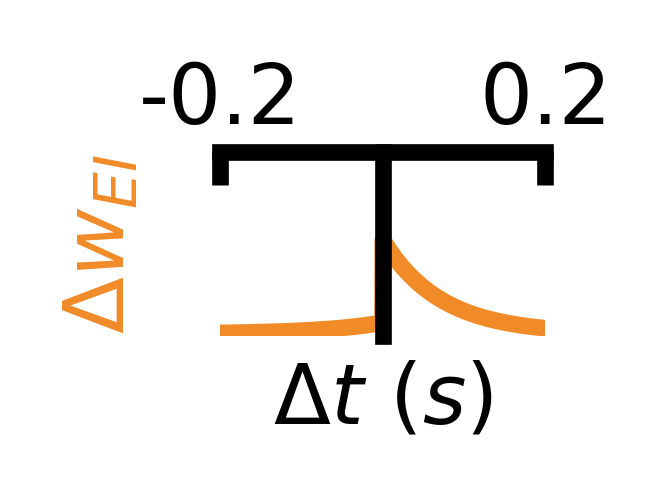

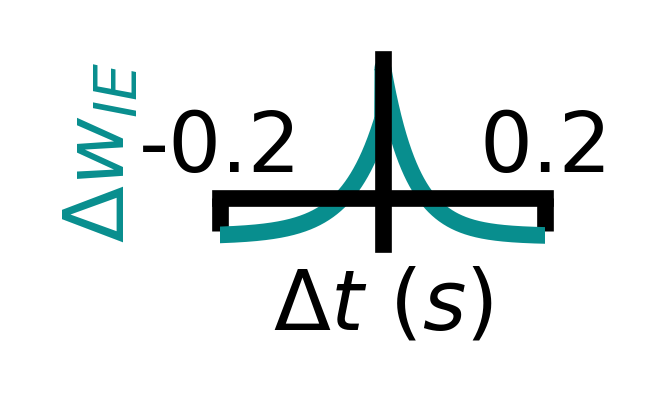

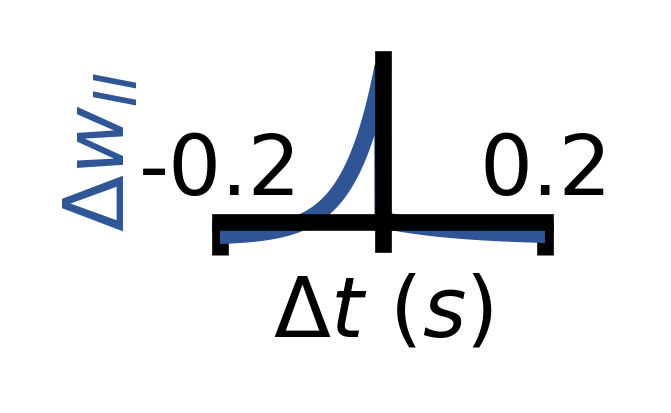

In [9]:
thetas_good_posterior_lowrinp = [[0.04660005, 0.02327882, 0.49659052, -0.35899994, -0.37540221, -1.278193, 
                                  0.0707294, 0.07955258, 0.63596439, -1.72025657, 0.56049812, 0.06629736,
                                  0.03651253, 0.04398145, -0.31592822, -0.04090761, 1.60054791,
                                  1.11010623, 0.09858324, 0.04056259, -1.94945908, 1.7757206 , 0.19681023, 1.9772824,
                                  6]]
thetas = thetas_good_posterior_lowrinp

aux.plot_rule(thetas=thetas[0][0:6], n_bins=1000, x_lim=[-0.2,0.2],
          y_ticks=[],x_ticks=[-0.2,0.2], x_ticklabels=[-0.2,0.2], x_label=r'$\Delta t \ (s)$',
          y_label=r'$\Delta w_{EE}$', color=color_ee, color_ylabel=color_ee, figsize=(0.7,0.4), 
              labelpad_xlabel=8, fontsize=10,
              labelpad_ylabel=25, linewidth=2, axwidth=2, dpi=600,
             xticks_pad=0, yticks_pad=0)

aux.plot_rule(thetas=thetas[0][6:12], n_bins=1000, x_lim=[-0.2,0.2], y_lim=[-1.1,0],
          y_ticks=[],x_ticks=[-0.2,0.2], x_ticklabels=[-0.2,0.2], x_label=r'$\Delta t \ (s)$',
          y_label=r'$\Delta w_{EI}$', color=color_ei, color_ylabel=color_ei, figsize=(0.7,0.4), 
              labelpad_xlabel=21, fontsize=10,
              labelpad_ylabel=25, linewidth=2, axwidth=2, dpi=600,
             xticks_pad=-15, yticks_pad=0)

aux.plot_rule(thetas=thetas[0][12:18], n_bins=1000, x_lim=[-0.2,0.2],
          y_ticks=[],x_ticks=[-0.2,0.2], x_ticklabels=[-0.2,0.2], x_label=r'$\Delta t \ (s)$',
          y_label=r'$\Delta w_{IE}$', color=color_ie, color_ylabel=color_ie, figsize=(0.7,0.4), 
              labelpad_xlabel=4, fontsize=10,
              labelpad_ylabel=25, linewidth=2, axwidth=2, dpi=600,
             xticks_pad=-15, yticks_pad=0)

aux.plot_rule(thetas=thetas[0][18:24], n_bins=1000, x_lim=[-0.2,0.2],
          y_ticks=[],x_ticks=[-0.2,0.2], x_ticklabels=[-0.2,0.2], x_label=r'$\Delta t \ (s)$',
          y_label=r'$\Delta w_{II}$', color=color_ii, color_ylabel=color_ii, figsize=(0.7,0.4), 
              labelpad_xlabel=2, fontsize=10,
              labelpad_ylabel=25, linewidth=2, axwidth=2, dpi=600,
             xticks_pad=-15, yticks_pad=0)